<a href="https://colab.research.google.com/github/charlesdgburns/NM_TinyRNN/blob/main/notebooks/nm_tinyrnn_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's use this as a learning notebook about different RNN mechanics - how do they solve the reversal learning task?

Here we are studying networks that have been pre-trained and selected (see the notebook `train_and_select_RNNs`).

These example networks should be stored in an `example` subfolder (if you've cloned the git)

In [1]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git
from pathlib import Path
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


fatal: destination path 'NM_TinyRNN' already exists and is not an empty directory.


In [2]:
# set paths not on google colab
from pathlib import Path
import os
#CODE_DIR = Path(Path(r'.'))
#os.chdir(CODE_DIR)
CODE_DIR = Path('.')
DATA_PATH = CODE_DIR/'NM_TinyRNN/data'
EXAMPLE_PATH = DATA_PATH/'rnns/example'


In [3]:
# Import packages and local code
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns
from NM_TinyRNN.code.measures import analysis
from importlib import reload #for active development


In [4]:
# let's load all our models and data !
# you can substitute EXAMPLE_PATH for any subject-level folder
reload(analysis)
model_dict = {}
for model_type_dir in EXAMPLE_PATH.iterdir():
    model_ids = [x.stem[:-5] for x in model_type_dir.iterdir() if '_info' in x.stem]
    for model_id in model_ids:
        filepaths = [x for x in model_type_dir.iterdir() if model_id in x.stem]
        data_dict = {}
        for data_type in ['model_state','info','trials_data','training_losses']:
            filepath = [f for f in filepaths if data_type in f.stem][0]
            data_dict[data_type] = analysis.load_data(str(filepath)) 
        model_dict[model_id] = data_dict
        
# in future we probably want a nifty class that does a lot of utility for us. 
# this will have to do for now :)

/tmp/ipykernel_126662/2524960057.py:26: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


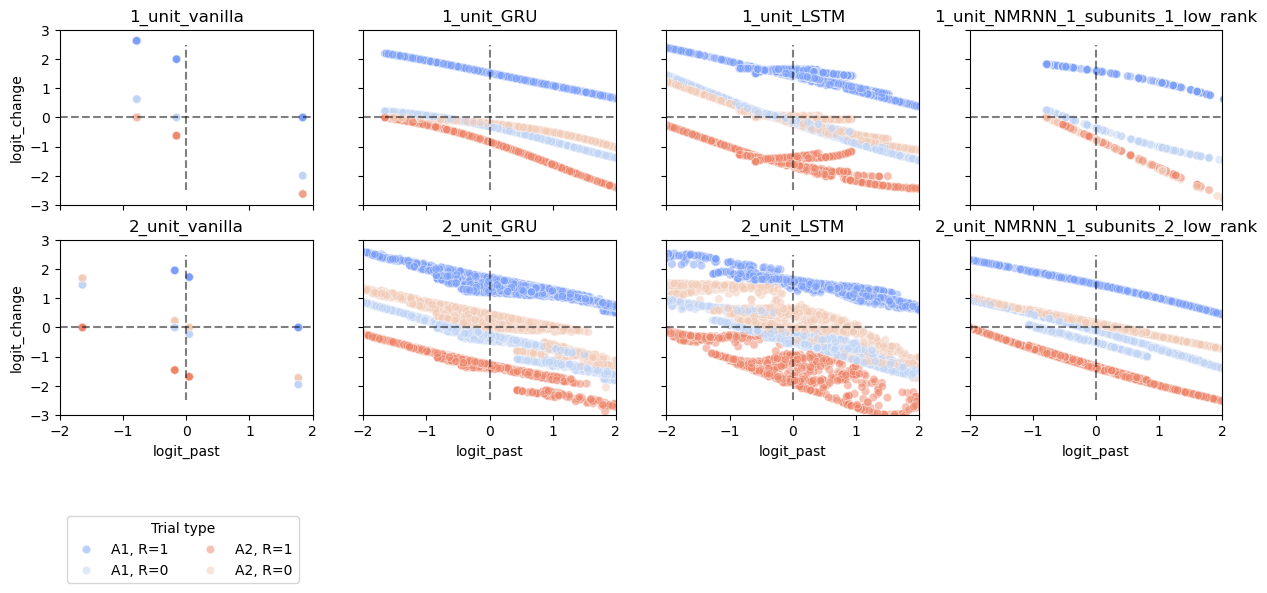

In [5]:
# plotting logits for 1 unit and 2 unit standard architectures
plot_ids = ['1_unit_vanilla','1_unit_GRU','1_unit_LSTM','1_unit_NMRNN_1_subunits_1_low_rank',
             '2_unit_vanilla','2_unit_GRU','2_unit_LSTM','2_unit_NMRNN_1_subunits_2_low_rank']

fig, axes = plt.subplots(2,4, figsize = (15,5), sharex=True, sharey=True)
flat_ax = axes.flatten()

palette = sns.color_palette('coolwarm',4)
palette[2],palette[3] = palette[3], palette[2] #reordercolorpalette
for i,each_model in enumerate(plot_ids):
    df = model_dict[each_model]['trials_data']
    sns.scatterplot(df, x='logit_past',y='logit_change',hue='trial_type',
                    palette=palette ,ax=flat_ax[i], alpha  = 0.5,)
    flat_ax[i].set(title = f'{each_model}', xlim = (-2,2),ylim=(-3,3))
    flat_ax[i].vlines(x=0,ymin=-2.5,ymax=2.5, 
                      linestyle = '--', color = 'black',alpha =0.5)
    flat_ax[i].hlines(y=0, xmin=-2,xmax=2,
                      linestyle = '--', color = 'black',alpha =0.5)
    if i==0:
        sns.move_legend( flat_ax[i], "lower left",
                        bbox_to_anchor=(0.0, -2.2), ncol=2, 
                        title='Trial type', frameon=True, )
    else:
        flat_ax[i].get_legend().remove()
        
fig.tight_layout()

**Figure: logit plots of standard architectures**. For each model architecture and dimensionality, we plot the change in logit as a function of the past logit, coloured by trial type. We also plot vertical and horizontal striped lines to indicate the 0 axes. Note that points crossing the horizontal axis are by definition fixed points since the change in logit is 0 here. *All architecures discover a choice bias, but the discovered cognitive strategy depends on the architecture.*


Below, we dive deeper into the different strateies of each model, looking at weights, and hidden activations of gates. We hope to reach an understanding of the mechanisms each model uses to predict the animals choices.

## Vanilla RNNs

The vanilla RNNs are quite simple to understand - their logits are quite easy to read!

Recall that they are governed by:
$$ h_t = W_{ih} x_t + b_{ih} + w_{hh} h_{t-1} + b_{hh} $$

### 1D

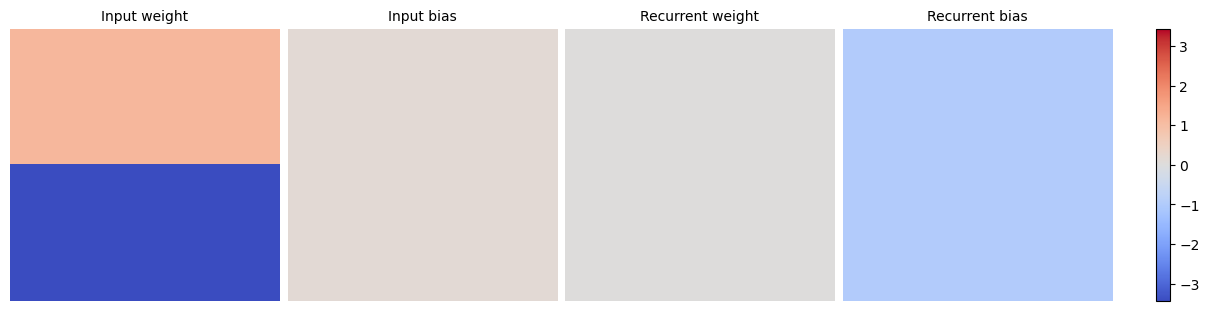

In [6]:
import matplotlib.pyplot as plt

weights = model_dict['1_unit_vanilla']['model_state']

mats = [
    weights['rnn.weight_ih_l0'].T,  # input → hidden
    weights['rnn.bias_ih_l0'][None, :],  # input bias (make 2D for imshow)
    weights['rnn.weight_hh_l0'].T,  # hidden → hidden
    weights['rnn.bias_hh_l0'][None, :],  # recurrent bias
]

titles = ["Input weight", "Input bias", "Recurrent weight", "Recurrent bias"]

# determine global vmin/vmax for consistent color scale
all_vals = np.concatenate([m.ravel() for m in mats])
vmin, vmax = -np.abs(all_vals).max(), np.abs(all_vals).max()

fig, axes = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)

ims = []
for ax, mat, title in zip(axes, mats, titles):
    im = ax.imshow(mat, aspect="auto", vmin=vmin, vmax=vmax, cmap="coolwarm")
    ax.set_title(title, fontsize=10)
    ax.axis("off")
    ims.append(im)

# shared colorbar
fig.colorbar(ims[0], ax=axes, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()


recall that the inputs are ordered as `outcome` then `choice`.

We can consider the behaviour in terms of the four trial types. 

For example, **if `choice` is 0** the input weight needs to balance out with the sum of the biases (which it does) whenever there's a positive outcome. Otherwise, the biases need to move the network to a fixed point between the two choices. If there's two negative outcomes in a row, the network stays at a fixed point, exactly where $W_{hh}h_{t-1}$ is equal to the biases.

**if `choice` is 1** the input weights drag the network to a negative state when outcome is $0$. If there is a negative outcome again, it might still be dragged further down. To know for sure, we can take another look at the logit readout of the hidden state below.

<Axes: xlabel='trial_type', ylabel='logit_past'>

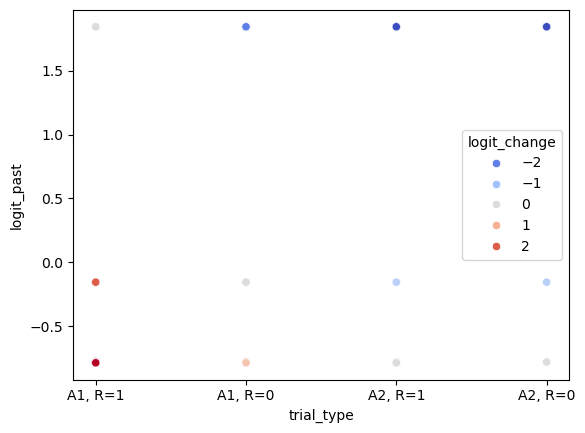

In [7]:
# here's an alternate view of the logit plot. 
# Here we more clearly see the three possible hidden states, 
# and how the trial type affects the hidden state (depending on the past state/logit)
trials_df = model_dict['1_unit_vanilla']['trials_data']
sns.scatterplot(trials_df,x='trial_type', y='logit_past', 
                hue='logit_change', palette='coolwarm')

Alternate view of logit plot makes the bias towards A1 very clear: even if unrewarded, if the network is in the uncertain state, it is still more likely to choose A1 and will stay in this uncertain state even if unrewarded.

<Axes: xlabel='None', ylabel='good_poke'>

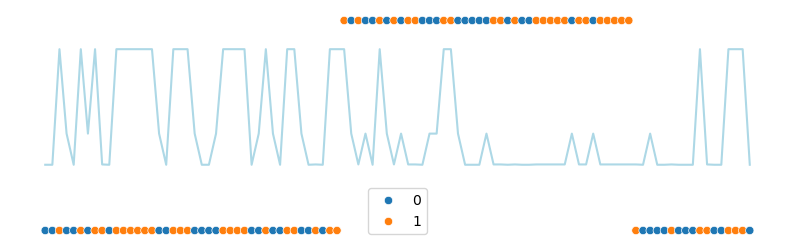

In [8]:
#We can see the model's behaviour in action. 
# Plotting a scatter for which side is the 'good poke', colored by outcome
# also plotting the probability of choosing one of the pokes.
trials_df = model_dict['1_unit_vanilla']['trials_data']
plot_df = trials_df.iloc[5000:5100]
fig, ax = plt.subplots(figsize=(10,3))
ax.axis('off')
sns.scatterplot(plot_df, x = plot_df.index, y='good_poke',hue='outcome', 
                ax = ax)
sns.lineplot(plot_df, x = plot_df.index, y='prob_A',c='lightblue', ax = ax)


## Gated Recurrent Units

Recall that they are governed by the following equations:

\begin{align}
r_t &= \sigma(W_{ir}x_{t-1}+W_{hr}h_{t-1}+b_{r})  &&\text{(reset gate)} \\
z_t &= \sigma(W_{iz}x_{t-1}+W_{hz}h_{t-1}+b_{z})  &&\text{(update gate)} \\
n_t &= \tanh(W_{in}x_{t-1}+b_{in}+r_{t}\cdot (W_{hn}h_{t-1}+b_{hn})) &&\text{(new state)}
\\
h_t &= (1-z_t)\cdot h_{t-1} +z_t \cdot n_t &&\text{(hidden state)}
\end{align}


### 1D

In [12]:
# Look at some weights? This might be hard to understand / read.


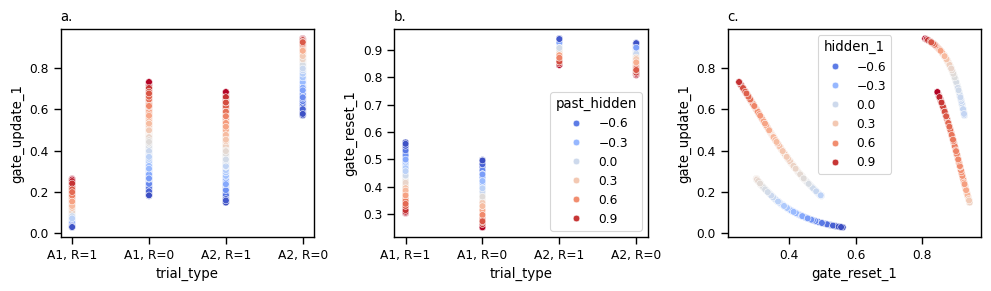

In [40]:
# Recall that the AB task has 4 trial types. Let's look at gate activations for each
# again we will use the logit as a linear readout of hidden state
sns.set_context('paper')
trials_df = model_dict['1_unit_GRU']['trials_data']
fig, ax = plt.subplots(1,3, figsize=(10,3))

trials_df['past_hidden'] = np.concatenate([[np.nan],trials_df.hidden_1.values[:-1]])

sns.scatterplot(trials_df,x='trial_type',y='gate_update_1',
                hue='past_hidden', ax = ax[0], palette='coolwarm',
                legend=False)
sns.scatterplot(trials_df,x='trial_type',y='gate_reset_1',
                hue='past_hidden', ax = ax[1], palette='coolwarm')
sns.scatterplot(trials_df,x='gate_reset_1',y='gate_update_1',
                hue='hidden_1', palette='coolwarm', ax = ax[2])
[ax[i].set_title(f'{x}', loc='left') for i,x in enumerate(['a.','b.','c.'])]
fig.tight_layout()

**Figure:** gate activations as a function of $h_{t-1}$ (hue) and $x_t$ (trial type). **a.** the update gate is sensitive to reward, with higher update values for unrewarded trials. Here we also notice a choice bias to update less for trials on the A1 side. **b.** the reset gate is sensitive to choice, with larger reset values for A2 choices regardless of outcome. **c.** we plot how the update gate and reset gate relates to the upcoming hidden state (given by hue). Note that the division across reset gate values is caused by the choice bias.